In [1]:
from tqdm import trange
from transformers import GPT2DoubleHeadsModel
import torch
import torch.nn as nn
from transformers import GPT2Tokenizer, BertTokenizer, BertForSequenceClassification, BertModel
import numpy as np
from torch.nn import CrossEntropyLoss
from transformers import AdamW

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Load Dataset

In [3]:
import pandas as pd

directory = '../data/bot_detection/'
train = pd.read_csv(directory + "train.csv", header=None)
test = pd.read_csv(directory + "test.csv", header=None)

train = pd.DataFrame({
    'id':range(len(train)),
    'label':train[0],
    'mark':['a']*train.shape[0],
    'text': train[1].replace(r'\n', ' ', regex=True)
})

test = pd.DataFrame({
    'id':range(len(test)),
    'label':test[0],
    'mark':['a']*test.shape[0],
    'text': test[1].replace(r'\n', ' ', regex=True)
})

train.columns = ["index", "label", "mark", "tweet"]
test.columns =  ["index", "label", "mark", "tweet"]

## Preprocessing

In [4]:
model_name = "BERT"

if model_name == "BERT":
    train_sentences = train.tweet.values
    train_sentences = ["[CLS] " + sentence + " [SEP]" for sentence in train_sentences]
    train_labels = train.label.values

    test_sentences = test.tweet.values
    test_sentences = ["[CLS] " + sentence + " [SEP]" for sentence in test_sentences]
    test_labels = test.label.values

elif model_name == "gpt2":
    train_sentences = train.tweet.values
    train_labels = train.label.values
    test_sentences = test.tweet.values
    test_labels = test.label.values

In [5]:
max_length = 128
if model_name == "BERT":
    tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)
elif model_name == "gpt2":
    tokenizer = GPT2Tokenizer.from_pretrained('gpt2', do_lower_case=True)
    
train_input_ids = [tokenizer.encode(sent) for sent in train_sentences]
test_input_ids = [tokenizer.encode(sent) for sent in test_sentences]

In [6]:
from keras.preprocessing.sequence import pad_sequences
MAX_LEN = 128
train_input_ids = pad_sequences(train_input_ids, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")
test_input_ids = pad_sequences(test_input_ids, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")

In [7]:
train_inputs = torch.tensor(train_input_ids).cuda()
train_labels = torch.tensor(train_labels).cuda()

test_inputs = torch.tensor(test_input_ids).cuda()
test_labels = torch.tensor(test_labels).cuda()

### Create the generators

In [8]:
from torch.utils.data import (DataLoader, RandomSampler, TensorDataset)
batch_size = 8
train_data = TensorDataset(train_inputs, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

test_data = TensorDataset(test_inputs, test_labels)
test_sampler = RandomSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=batch_size)

### Model and parameters

In [9]:
if model_name == "BERT":
    model = torch.load('../models/BERT_Classifier_Large.pt')
elif model_name == "gpt2":
    model = torch.load('../models/Gpt2_Classifier_Large.pt')

/home/test/anaconda3/envs/bots/lib/python3.8/site-packages/torch/serialization.py:657: SourceChangeWarning: source code of class 'torch.nn.modules.sparse.Embedding' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/home/test/anaconda3/envs/bots/lib/python3.8/site-packages/torch/serialization.py:657: SourceChangeWarning: source code of class 'torch.nn.modules.normalization.LayerNorm' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/home/test/anaconda3/envs/bots/lib/python3.8/site-packages/torch/serialization.py:657: SourceChangeWarning: source code of class 'torch.nn.modules.dropout.Dropout' has changed. you can retrieve the ori

Choose either if you want to use all the embeddings of the first embedding layer, or just the last token embedding (for GPT2), or BERT (first token)

In [10]:
linear = nn.Linear(98304, 2).to(torch.device("cuda:0")) #98304 = 128*768

In [11]:
param_optimizer = list(linear.named_parameters())
no_decay = ['bias', 'gamma', 'beta']
optimizer_grouped_parameters = [
    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.01},
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.0}
]

optimizer = AdamW(optimizer_grouped_parameters,
                     lr=2e-5,)

## Training

In [14]:
#input_ids=train_inputs[0].unsqueeze(0)
if model_name=="BERT":
    model.bert.config.output_hidden_states = True
    model.bert.config.is_decoder = False
    model.bert.encoder.output_hidden_states = True
    for i in range(0,len(model.bert.encoder.layer)): 
        model.bert.encoder.layer[i].is_decoder = False
        model.bert.encoder.layer[i].output_hidden_states = True
else:
    model.transformer.output_hidden_states = True

In [17]:
# Store our loss and accuracy for plotting
train_loss_set = []

# Number of training epochs (authors recommend between 2 and 4)
epochs = 2

# trange is a tqdm wrapper around the normal python range
for _ in trange(epochs, desc="Epoch"):
  # Training
  
  # Set our model to training mode (as opposed to evaluation mode)
  linear.train()
    
  for step, batch in enumerate(train_dataloader):
    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)
    # Unpack the inputs from our dataloader
    b_input_ids, b_labels = batch
    optimizer.zero_grad()
    if(model_name=="gpt2"):
        outputs = model.transformer(b_input_ids)
        h0 = outputs[3][0] ## Here we are using embeddings layer 
        logits = linear(h0.view(-1,98304)) ## We flat the embeddings
    else:
        h0 = model.bert.embeddings(b_input_ids)
        logits = linear(h0.view(-1,98304))
        
    loss_fct = CrossEntropyLoss()
    loss=loss_fct(logits.view(-1, logits.size(-1)),
                            b_labels.view(-1))
    train_loss_set.append(loss.item())
    loss.backward()
    optimizer.step()

Epoch:   0%|          | 0/2 [00:00<?, ?it/s]/opt/conda/conda-bld/pytorch_1591914743399/work/torch/csrc/utils/python_arg_parser.cpp:756: UserWarning: This overload of add_ is deprecated:
	add_(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add_(Tensor other, *, Number alpha)
Epoch: 100%|██████████| 2/2 [06:39<00:00, 199.68s/it]


### Learning curve

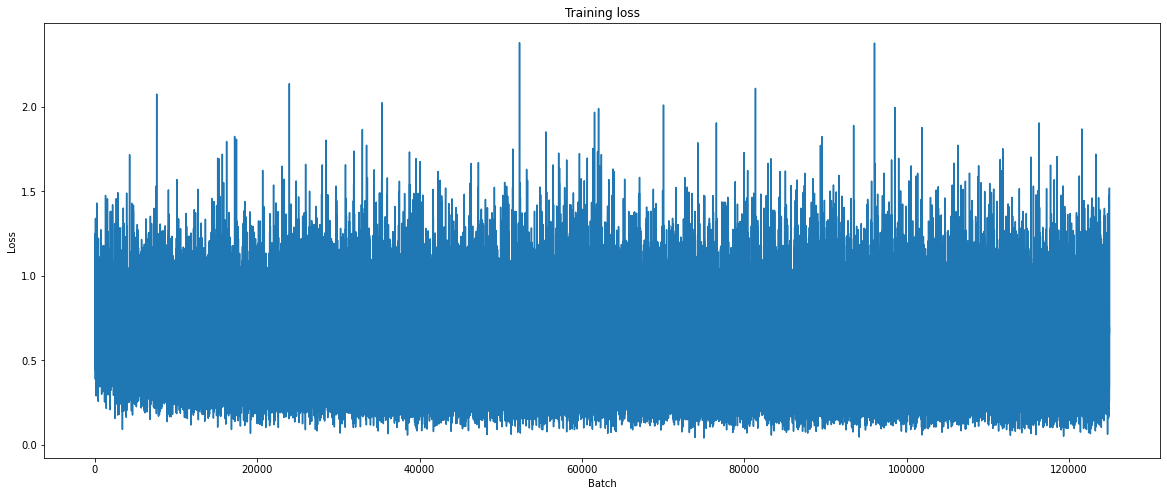

In [18]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,8))
plt.title("Training loss")
plt.xlabel("Batch")
plt.ylabel("Loss")
plt.plot(train_loss_set)
plt.show()

## Evaluation.

In [19]:
preds = []

for i in range(int(len(test_inputs)/10)):
    batch = (test_inputs[i*10: (i+1)*10].to(device))
    with torch.no_grad():
        if(model_name=="gpt2"):
            outputs = model(batch)
            h0 = outputs[3][0]
            logits = linear(h0.view(-1,98304))
        else:
            h0 = model.bert.embeddings(batch)
            logits = linear(h0.view(-1,98304))
    
    logits = logits.detach().cpu().numpy()
    preds.append(logits)
    if i%100 == 0:
        print("Processing: ", i*10/1000, "%")

Processing:  0.0 %
Processing:  1.0 %
Processing:  2.0 %
Processing:  3.0 %
Processing:  4.0 %
Processing:  5.0 %
Processing:  6.0 %
Processing:  7.0 %
Processing:  8.0 %
Processing:  9.0 %
Processing:  10.0 %
Processing:  11.0 %
Processing:  12.0 %
Processing:  13.0 %
Processing:  14.0 %
Processing:  15.0 %
Processing:  16.0 %
Processing:  17.0 %
Processing:  18.0 %
Processing:  19.0 %
Processing:  20.0 %
Processing:  21.0 %
Processing:  22.0 %
Processing:  23.0 %
Processing:  24.0 %
Processing:  25.0 %
Processing:  26.0 %
Processing:  27.0 %
Processing:  28.0 %
Processing:  29.0 %
Processing:  30.0 %
Processing:  31.0 %
Processing:  32.0 %
Processing:  33.0 %
Processing:  34.0 %
Processing:  35.0 %
Processing:  36.0 %
Processing:  37.0 %
Processing:  38.0 %
Processing:  39.0 %
Processing:  40.0 %
Processing:  41.0 %
Processing:  42.0 %
Processing:  43.0 %
Processing:  44.0 %
Processing:  45.0 %
Processing:  46.0 %
Processing:  47.0 %
Processing:  48.0 %
Processing:  49.0 %
Processing

### BERT Results

In [ ]:
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
predictions = []
for pred in preds:
    p = np.argmax(pred, axis = 1)
    for label in p:
        predictions.append(label)
print(classification_report(np.asarray(test["label"][:len(predictions)]), predictions, digits = 4))
print("Accuracy: ", accuracy_score(np.asarray(test["label"][:len(predictions)]), predictions))

              precision    recall  f1-score   support

           0     0.7517    0.7779    0.7646     55712
           1     0.7078    0.6768    0.6920     44288

    accuracy                         0.7331    100000
   macro avg     0.7298    0.7274    0.7283    100000
weighted avg     0.7323    0.7331    0.7324    100000

Accuracy:  0.73313


### OpenAI GPT2 Results

In [ ]:
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
predictions = []
for pred in preds:
    p = np.argmax(pred, axis = 1)
    for label in p:
        predictions.append(label)
print(classification_report(np.asarray(test["label"][:len(predictions)]), predictions, digits = 4))
print("Accuracy: ", accuracy_score(np.asarray(test["label"][:len(predictions)]), predictions))

              precision    recall  f1-score   support

           0     0.7776    0.6625    0.7154     55712
           1     0.6420    0.7616    0.6967     44288

    accuracy                         0.7064    100000
   macro avg     0.7098    0.7120    0.7061    100000
weighted avg     0.7175    0.7064    0.7071    100000

Accuracy:  0.70637
